# GIS with Python: 6 libraries to know

<br/>
## A presentation for NICAR 2017
github.com/robroc/GIS-with-python
<br />
<br />
## Roberto Rocha
### CBC/Radio-Canada
### @robroc

## Why do GIS with Python when there's QGIS, etc?

Like any reptitive, recurring task that benefits from scripting, you can also automate GIS work with Python.

This notebook demos six libraries that can help you do the following:

- Analyze data feeds from APIs or other data that's updated regularly
- Churning out maps based on templates
- Quickly seeing geospatial data in Jupyter

# Shapely

- #### High-level interface to GEOS library (OGR and GDAL)
- #### PostGIS-like geometry operations outside of a database
- #### Doesn’t read and write files

`pip install shapely`

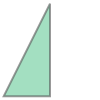

In [1]:
# Create a polygon from 3 points

from shapely.geometry import Polygon, Point

polygon = Polygon([(45.55, -73.62), (45.54, -73.62), (45.55, -73.60)])
polygon

In [46]:
# Show three attributes of the polygon

print("Area: " + str( polygon.area ))
print("Length: " + str( polygon.length ))
print("Bounding box: " + str( polygon.bounds ))

Area: 0.00010000000000003127
Length: 0.0523606797750144
Bounding box: (45.54, -73.62, 45.55, -73.6)


In [12]:
# The polygon's centroid in WKT

polygon.centroid.wkt

'POINT (45.54666666666666 -73.61333333333333)'

In [3]:
# Create a point. Is it inside the polygon?

point = Point(45.545, -73.613)
polygon.contains(point)

True

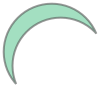

In [4]:
# Make another point, create a buffer on both.
# Show the difference between the two buffers

area1 = point.buffer(0.3)
area2 = Point(45.6, -73.7).buffer(0.3)
area1.difference(area2)

0.22088665857268447


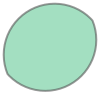

In [5]:
# Show where they intersect

print(area2.intersection(area1).area)
area2.intersection(area1)

You're probably not analyzing one point or polygon at a time. These Shapely classes are more useful:
- LineStrings
- MultiPoints
- MultiLineStrings
- MultiPolygons


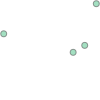

In [6]:
# Let's look at MultiPoints

from shapely.geometry import MultiPoint

p = [(45.65, -73.63), (45.70, -73.60), (45.35, -73.55), (45.75, -73.42)]

points = MultiPoint(p)
points

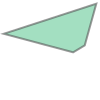

In [7]:
# Find the smallest polygon that contains all the points

points.convex_hull

In [7]:
# Do the points fall within the polygon we created earlier?

points.within(polygon)

False

# Fiona

- #### Data access only
- #### No manipulation
- #### Very basic analysis
- #### Outputs GeoJSON by default

`pip install fiona`

In [14]:
# Open a shapefile and check its CRS/projection

import fiona

shapefile = '../../Map files/Montreal/Addresses/adresse/ADRESSE.shp'

f = fiona.open(shapefile)
f.crs

{'datum': 'NAD83',
 'k': 0.9999,
 'lat_0': 0,
 'lon_0': -73.5,
 'no_defs': True,
 'proj': 'tmerc',
 'units': 'm',
 'x_0': 304800,
 'y_0': 0}

In [49]:
# Read information about attributes

f.schema

{'geometry': 'Point',
 'properties': OrderedDict([('TEXTE', 'str:100'),
              ('SPECIFIQUE', 'str:50'),
              ('ORIENTATIO', 'str:5'),
              ('LIEN', 'str:12'),
              ('ID_ADRESSE', 'float:38'),
              ('HAUTEUR', 'float:20'),
              ('GENERIQUE', 'str:12'),
              ('ANGLE', 'float:20.3'),
              ('ADDR_DE', 'float:20'),
              ('ADDR_A', 'float:20'),
              ('ADD_COMPL', 'str:60'),
              ('ADD_SHORT', 'str:50')])}

In [50]:
# Inspect one record

f[0]

{'geometry': {'coordinates': (297838.38, 5045518.61999946), 'type': 'Point'},
 'id': '0',
 'properties': OrderedDict([('TEXTE', '#6370'),
              ('SPECIFIQUE', '1re'),
              ('ORIENTATIO', None),
              ('LIEN', None),
              ('ID_ADRESSE', 197.0),
              ('HAUTEUR', 2.0),
              ('GENERIQUE', 'avenue'),
              ('ANGLE', 33.84),
              ('ADDR_DE', 6370.0),
              ('ADDR_A', 6370.0),
              ('ADD_COMPL', '#6370 avenue 1re'),
              ('ADD_SHORT', '#6370 avenue 1re')]),
 'type': 'Feature'}

In [51]:
# Fiona can do very basic geometry, like checking the bounds

f.bounds

(267685.66999999905, 5029250.76999946, 306394.889999999, 5062459.40999946)

### Possible use: homemade geocoder

Iterate though a collection of points, check if street numbers and name match the data in fiona, return coordinates.
 

In [22]:
# Example of a geocoding script using Montreal's address point data.
# It checks if an address matches a fiona feature by iterating through all features.
# Not the most efficient script, but I code like a journalist.

import time

# Function to check if street number is even to get coordinates
# on the right side of the street
def is_even(n):
    if n % 2 == 0: return True
    else: return False

start_time = time.time()

address = '4416 rue Garnier'.split(' ')

even_number = is_even(int(address[0]))

# Iterate thorugh fiona features and print the matching address and coordinates
for item in f.items():
    if ( even_number == is_even(item[1]['properties']['ADDR_DE']) and
         int(address[0]) >= item[1]['properties']['ADDR_DE'] and
         int(address[0]) <= item[1]['properties']['ADDR_A'] and
         address[1] == item[1]['properties']['GENERIQUE'] and
         address[2] == item[1]['properties']['SPECIFIQUE'] ):
        print(item[1]['properties']['ADD_COMPL'], item[1]['geometry']['coordinates'])
        break
        
print ("Lookup time: " + str(time.time() - start_time) + " seconds")

#4408-4416 rue Garnier (298905.39, 5043361.30999946)
Lookup time: 3.166003942489624 seconds


# Geopandas

- #### Pandas for geo data: based on GeoDataFrames
- #### Has all of pandas's powerful analysis tools
- #### Quick plotting
- #### Good for spatial joins
- #### Still young (version 0.2)

`pip install geopandas` or `conda install geopandas`

Note: dependencies can be a bit tricky to install, especially on Windows machines.

In [66]:
import geopandas

# Open a shapefile of Montreal's boroughs and municipalities
# Notice the geometry column, encoded in WKT

shapefile = shapefile = '../Map files/Montreal/Boroughs/LIMADMIN.shp'

boroughs = geopandas.read_file(shapefile)
boroughs.head()

,ABREV,AIRE,CODEID,CODEMAMROT,MUNID,NOM,NUM,PERIM,TYPE,geometry
0,OM,3.813356e+06,11,REM05,66023,Outremont,5,10836.670,Arrondissement,POLYGON ((-73.62077559344179 45.52365087960285...
1,LS,2.519727e+07,22,REM17,66023,LaSalle,18,25259.849,Arrondissement,POLYGON ((-73.66610411073152 45.42179736598723...
2,MR,7.445560e+06,62,66072,66023,Mont-Royal,2,18314.038,Ville liée,"POLYGON ((-73.6507508626002 45.52630735684696,..."
3,VM,2.150063e+07,9,REM19,66023,Ville-Marie,20,26585.959,Arrondissement,POLYGON ((-73.53012910755166 45.53475802657721...
4,PM,8.151665e+06,5,REM21,66023,Le Plateau-Mont-Royal,22,13158.328,Arrondissement,POLYGON ((-73.55923068985261 45.53989862427608...


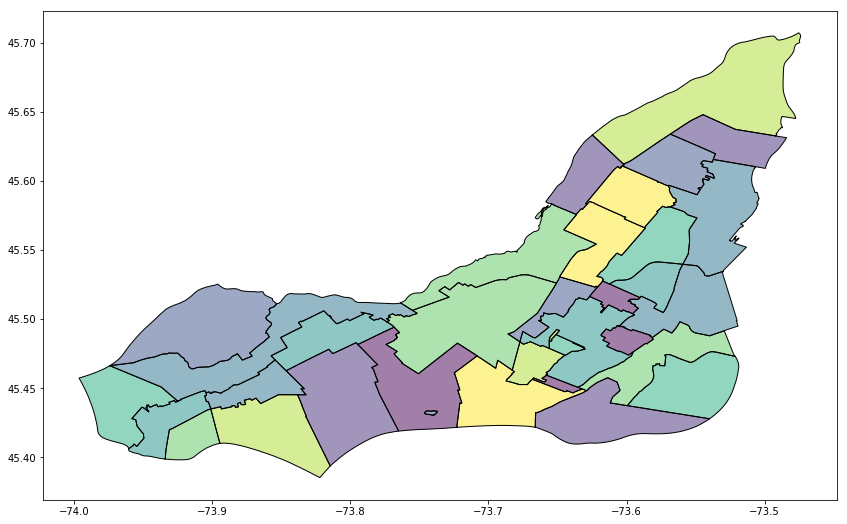

In [67]:
# Quickly see what it looks like

%matplotlib inline

boroughs.plot(figsize=(15,9))

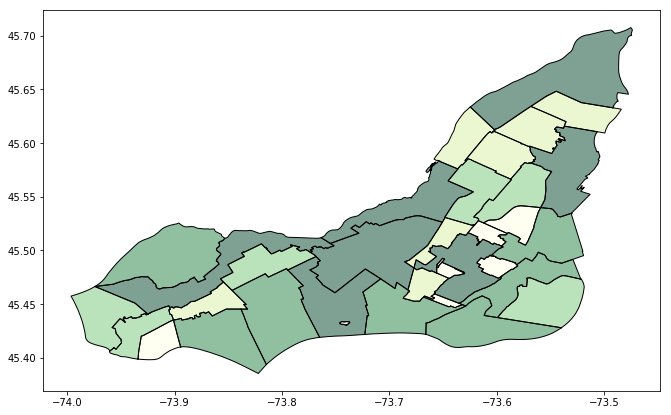

In [100]:
# Make a choropleth map based on the perimeter column

boroughs.plot(column='PERIM', 
           scheme='quantiles', 
           k=5, 
           cmap='YlGn', 
           figsize=(13,7))

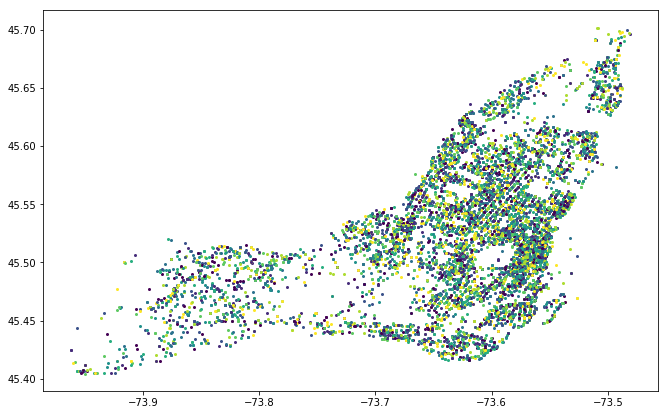

In [57]:
# Load Montreal fire dept. intervention CSV with lat/lon columns
# We'll use Shapely to create geometry column

import pandas as pd

# Load data into a pandas dataframe
fire = pd.read_csv('Fire/donneesouvertes-interventions-sim-2016.csv')

# Convert datetime column to something pandas understands
fire['CREATION_DATE_TIME'] = pd.to_datetime(fire['CREATION_DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

# Filter the last month of 2016
fire = fire[fire.CREATION_DATE_TIME.dt.month > 11]

# Use Shapely's Point to create a geometry column
fire['geometry'] = fire.apply(lambda row: Point(row["LONGITUDE"], 
                                                row["LATITUDE"]), 
                              axis=1)

# Load into geopandas
geofire = geopandas.GeoDataFrame(fire)
geofire.plot(figsize=(13, 7))

In [84]:
# Do a spatial join (sjoin) on boroughs polygons and fire intervention points.
# Both datasets must have the same CRS (projection) for it to work.
# In this case, I know they do, so I assign the CRS from one to the other.
# The result is a geodataframe of all interventions with the attributes of the boroughs they are in

geofire.crs = boroughs.crs
per_borough = geopandas.tools.sjoin(geofire, 
                                    boroughs, 
                                    how='left', 
                                    op='within')
per_borough.head()

,INCIDENT_NBR,CREATION_DATE_TIME,INCIDENT_TYPE_DESC,CASERNE,NOM_VILLE,NOM_ARROND,DIVISION,LATITUDE,LONGITUDE,NOMBRE_UNITES,...,index_right,ABREV,AIRE,CODEID,CODEMAMROT,MUNID,NOM,NUM,PERIM,TYPE
111871,120262,2016-12-01 00:05:04,Ac.véh./1R/s.v./ext/29B/D,57,Montréal,Pierrefonds / Roxboro,1,45.503287,-73.756815,1.0,...,30.0,PR,3.376527e+07,38,REM31,66023.0,Pierrefonds-Roxboro,13.0,51360.092,Arrondissement
111872,120263,2016-12-01 00:26:03,Aliments surchauffés,73,Montréal,Saint-Laurent,3,45.516438,-73.684442,5.0,...,24.0,LR,4.307785e+07,29,REM15,66023.0,Saint-Laurent,15.0,36589.407,Arrondissement
111873,120264,2016-12-01 00:27:28,Premier répondant,56,Montréal,L'Ile-Bizard / Ste-Geneviève,1,45.492324,-73.877568,1.0,...,11.0,IS,3.653251e+07,39,REM32,66023.0,L'Île-Bizard-Sainte-Geneviève,6.0,28399.248,Arrondissement
111874,120265,2016-12-01 00:28:00,Ac.véh./1R/s.v./ext/29B/D,34,Montréal,Côte-des-Neiges / Notre-Dame-de-Grâce,4,45.467706,-73.621402,2.0,...,22.0,CN,2.148375e+07,61,REM34,66023.0,Côte-des-Neiges-Notre-Dame-de-Grâce,27.0,35557.954,Arrondissement
111875,120266,2016-12-01 00:31:46,Ac.véh./1R/s.v./V.R./29B/D,52,Baie d'Urfé,Indéterminé,2,45.425117,-73.920683,3.0,...,33.0,BU,8.025921e+06,45,66112,66023.0,Baie-d'Urfé,71.0,11652.905,Ville liée


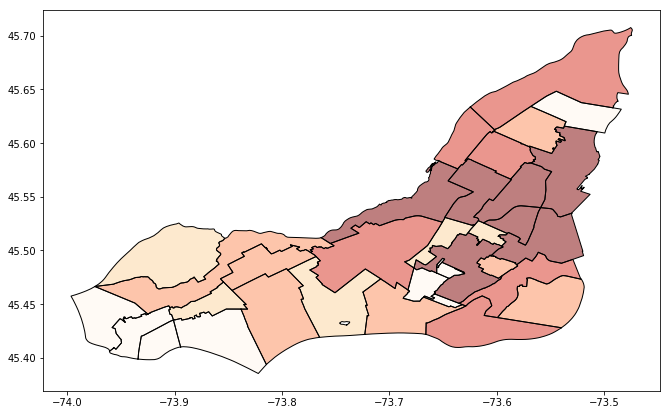

In [101]:
# Now we count the number of interventions per borough

# First, group the geodatagrame by borough name (NOM),
# count the number of records in each,
# keep only relevant columns
borough_count = per_borough.groupby('NOM').count()[['NUM', 'CASERNE']].reset_index()

# Merge (join) with the boroughs shapefile and plot it
boroughs_with_fire = boroughs.merge(borough_count, on='NOM')
boroughs_with_fire.plot(column='NUM_y', 
           scheme='quantiles', 
           k=5, 
           cmap='OrRd', 
           figsize=(13,7))

# Basemap

- #### An extension to matplotlib
- #### Make static maps with multiple layers
- #### Comes pre-loaded with world maps at several projections
- #### Installation is a little tricker. See the docs. With Anaconda:

`conda install -c anaconda basemap=1.0.7`

/Users/beto/anaconda/envs/geo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()


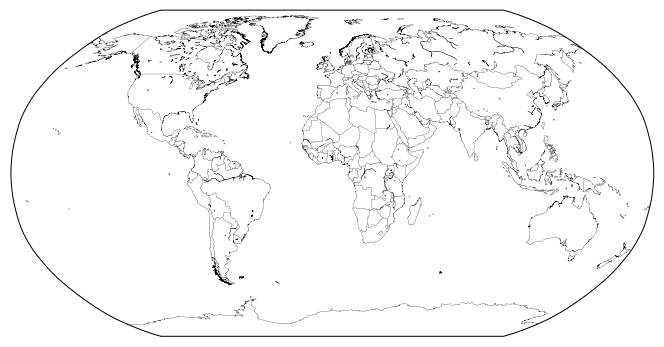

In [5]:
# Draw a basic world map in the Robinson projection

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

plt.figure(figsize=(12,6))
m = Basemap(projection='robin', lon_0=0, resolution='l')
m.drawcountries(linewidth=0.25)
m.drawcoastlines(linewidth=0.25)

In [15]:
# This long code is a function that creates a map in PNG format for every timestamp
# in scraped car2go API data. It loads several layers of shapefiles and iterates through
# a pandas dataframe grouped by time.

import pandas as pd
from IPython.display import clear_output

def make_map_slides(from_date, to_date):
    '''
    Create a map for every time stamp between two dates. 
    '''
    
    days = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    
    font = {'family': 'Arial',
        'color':  '#323F44',
        }
    
    # Map bounds zoomed in on Montreal
    coords = [-73.773869, 45.428756, -73.477991, 45.619950 ]
    w, h = coords[2] - coords[0], coords[3] - coords[1]
    extra = 0.01

    # df is a pandas dataframe with car2go API data at 5-minute intervals.
    # Group the data by timestamp to iterate through each one
    grouped = (df.set_index('time')
               .loc[from_date:to_date]
               .reset_index()
               .groupby('time') )
    
    n = 0
    for name, group in grouped:
        lats = group.lat.tolist()
        lons = group.lon.tolist()   
        
        # Initialize basemap
        m = Basemap(
            projection='tmerc',
            lon_0= -73.6,
            lat_0= 45.5,
            ellps = 'WGS84',
            llcrnrlon = coords[0] - extra * w,
            llcrnrlat = coords[1] - extra + 0.01 * h,
            urcrnrlon = coords[2] + extra * w,
            urcrnrlat = coords[3] + extra + 0.01 * h,
            lat_ts = 0,
            resolution = 'i',
            suppress_ticks = True)

        plt.figure(figsize=[14, 14])

        # Boroughs shapefile
        boroughs = "/Users/usr/Documents/Map files/Montreal/boroughs_and_munis/boroughs_and_munis-NAD83"
        m.readshapefile(
            boroughs,
            'montreal',
            color='firebrick',
            zorder=2,
            linewidth=2)

        # Main road arteries shapefile
        arteries = "/Users/usr/Documents/Map files/Montreal/geobasemtlshp/GEOBASE_MTL_arteries"
        m.readshapefile(
            arteries,
            'arteries',
            color='grey',
            zorder=1)
    
        # Plot the latitude and longitude points for each timestamp
        x, y = m(lons, lats)
        m.plot(x, y, 'bo', markersize=3)

        # Text of timestamp
        weekday = name.dayofweek
        day = days[weekday]
        time = name.strftime('%Y-%m-%d %H:%M')

        # Location of timestamp text on figure
        tx, ty = m(-73.755, 45.56)
        wx, wy = m(-73.755, 45.565)
        plt.text(tx, ty, time, fontdict=font, fontsize=16)
        plt.text(wx, wy, day, fontdict=font, fontsize=18, fontweight='bold')
        
        # Save figure as a PNG with name format 'frame0001.png'
        plt.savefig('animate/en/frame{}.png'.format(str(n).zfill(4)), bbox_inches='tight')
        
        plt.close()
        clear_output()
        print("Creating file {}".format(n))
        n += 1


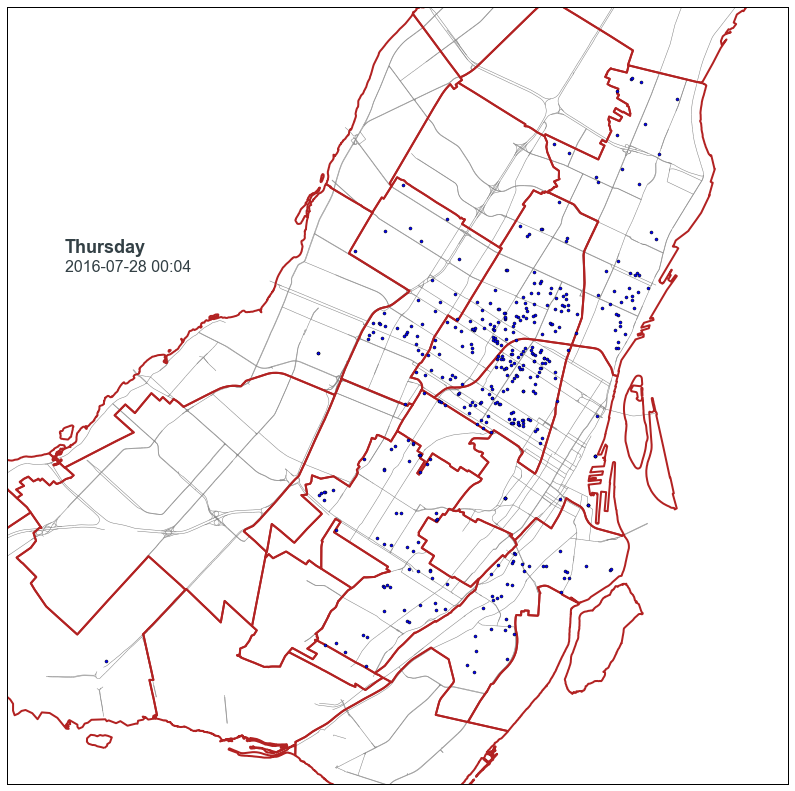

In [2]:
# Run the mapmaker function between two timestamps.
# Output below is the map of the first timestamp.

make_map_slides('2016-07-28 00:04:55','2016-07-30 23:56:01')

The function produced 850 PNG files. After using ImageMagick to make them into an animated GIF:

<img src="car2go_en.gif">

# Folium
- #### A Leaflet wrapper for Python
- #### Make interactive slippy maps right inside Jupyter

`pip install folium`

In [8]:
from folium import Map, CircleMarker, Popup

# Create blank map using the CartoDB Positron basemap
mymap = Map( location=[45.5, -73.6], 
            zoom_start=12, 
            tiles="cartodbpositron")

mymap 

# Note: Folium maps don't show up on GitHub. Download this notebook and try it on your machine.

In [9]:
# Add a circle marker
CircleMarker( location = [45.5, -73.6], 
            radius = 200, 
            popup = Popup('I\'m a marker!'),
            fill_color = 'maroon',
            fill_opacity = 0.7, 
            color=None
        ).add_to(mymap)

mymap.save('map.html')

In [10]:
# Create a vincent chart with fake data. Add it to a new marker. 
# Vega is a folium class that turns vincent charts into popup content

import pandas as pd
import numpy as np
from folium import Vega
from vincent import Bar

# Make fake data with numpy
data = pd.DataFrame(np.random.randint(0,100,size=(14, 2)), 
                    columns=list('AB'))

# This makes a vincent chart
chart = ( Bar(data, width=200,  height=100)
        .colors(range_=['#404040'])
        .axis_titles(x='A', y='B')
        )
chart.x_axis_properties(color='#9E9E9E', title_size=11)
chart.y_axis_properties(color='#9E9E9E', title_size=11)

# This turns that chart into a JSON item that folium can use in a popup
vega = Vega(vega.to_json(),
             width = vega.width+50, 
             height = vega.height+50 )

# Create a circle marker with the vega chart as the popup content
CircleMarker(
        location = [45.53, -73.64], 
        popup = Popup(max_width=250).add_child(vega), 
        radius = 250, 
        fill_color = 'blue', 
        fill_opacity = 0.8, 
        color = None
    ).add_to(mymap)


In [11]:
# Ta-da!

mymap

You can export the map as a complete HTML file with all the JavaScript and CSS in there. Warning that it's a bit heavy, with each feature having its own style section.

Here's a [Radio-Canada project](http://ici.radio-canada.ca/nouvelles/special/2016/11/montreal-car2go-covoiturage-vignettes-stationnement/) that used folium (and vincent) to export an interactive map showing car2go cluster in Montreal. The code to find the clusters using scikitlearn's k-means clustering [is here](http://nicolas.kruchten.com/content/2016/11/car2go-map/).

In [13]:
# Save the folium map

mymap.save('map.html')

# PySAL
- #### Python Spatial Analysis Library
- #### Power tool for GIS work
- #### Reads many types of files
- #### Advanced analysis like geometry manipulation, spatial autocorrelation, econometrics
- #### ESDA sub-package great for colour classification in choropleth maps

`pip install pysal` or a [Windows exe](http://pysal.readthedocs.io/en/latest/users/installation.html).

In [14]:
from pysal.esda.mapclassify import Natural_Breaks, Quantiles, Equal_Interval
import numpy as np

# Create fake data in exponential distribution and break it into 6 classes

data = np.random.exponential(3000, 200)

print("Natural breaks:")
print(Natural_Breaks( data, initial=200, k = 6).bins.tolist() )
print("")
      
print("Quantiles:")
print(Quantiles( data, k = 6).bins.tolist() )
print("")

print("Equal interval:")
print(Equal_Interval( data, k = 6).bins.tolist() )
print("")

Natural breaks:
[674.3316612541753, 1693.3062846262624, 2923.50692574417, 4905.466236613287, 8280.49399745373, 16514.589238678418]

Quantiles:
[771.2395120304774, 1396.8484630410856, 2217.528327601883, 3419.7360212269487, 5311.351264958465, 16514.589238678418]

Equal interval:
[2801.191392043492, 5543.870961370478, 8286.550530697463, 11029.23010002445, 13771.909669351435, 16514.589238678418]



## Honourable mentions


### GDAL
- #### The original universal GIS module. Everything is based on it
- #### Includes OGR (for vectors) and GDAL (for rasters)

### PyShp
- #### Reads and writes shapefiles

### dbfpy
- #### Reads and writes DBF files only

### geojson
- #### Reads and writes in the GeoJSON specification

### geopy
- #### Geocodes addresses into lat-lon coordinates